In [1]:
## math, plotting
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd
import scipy.stats

## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
sys.path.append('../../Beltway_Project/')
sys.path.append('../../RatterdamOpen_Project/')
sys.path.append('../DATA/')
sys.path.append('../../../ratterdam/')


import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2

(79107, 39)
starting 0 10000
starting 5000 15000
starting 10000 20000
starting 15000 25000
starting 20000 30000
starting 25000 35000
starting 30000 40000
starting 35000 45000
starting 40000 50000
starting 45000 55000
starting 50000 60000
starting 55000 65000
starting 60000 70000


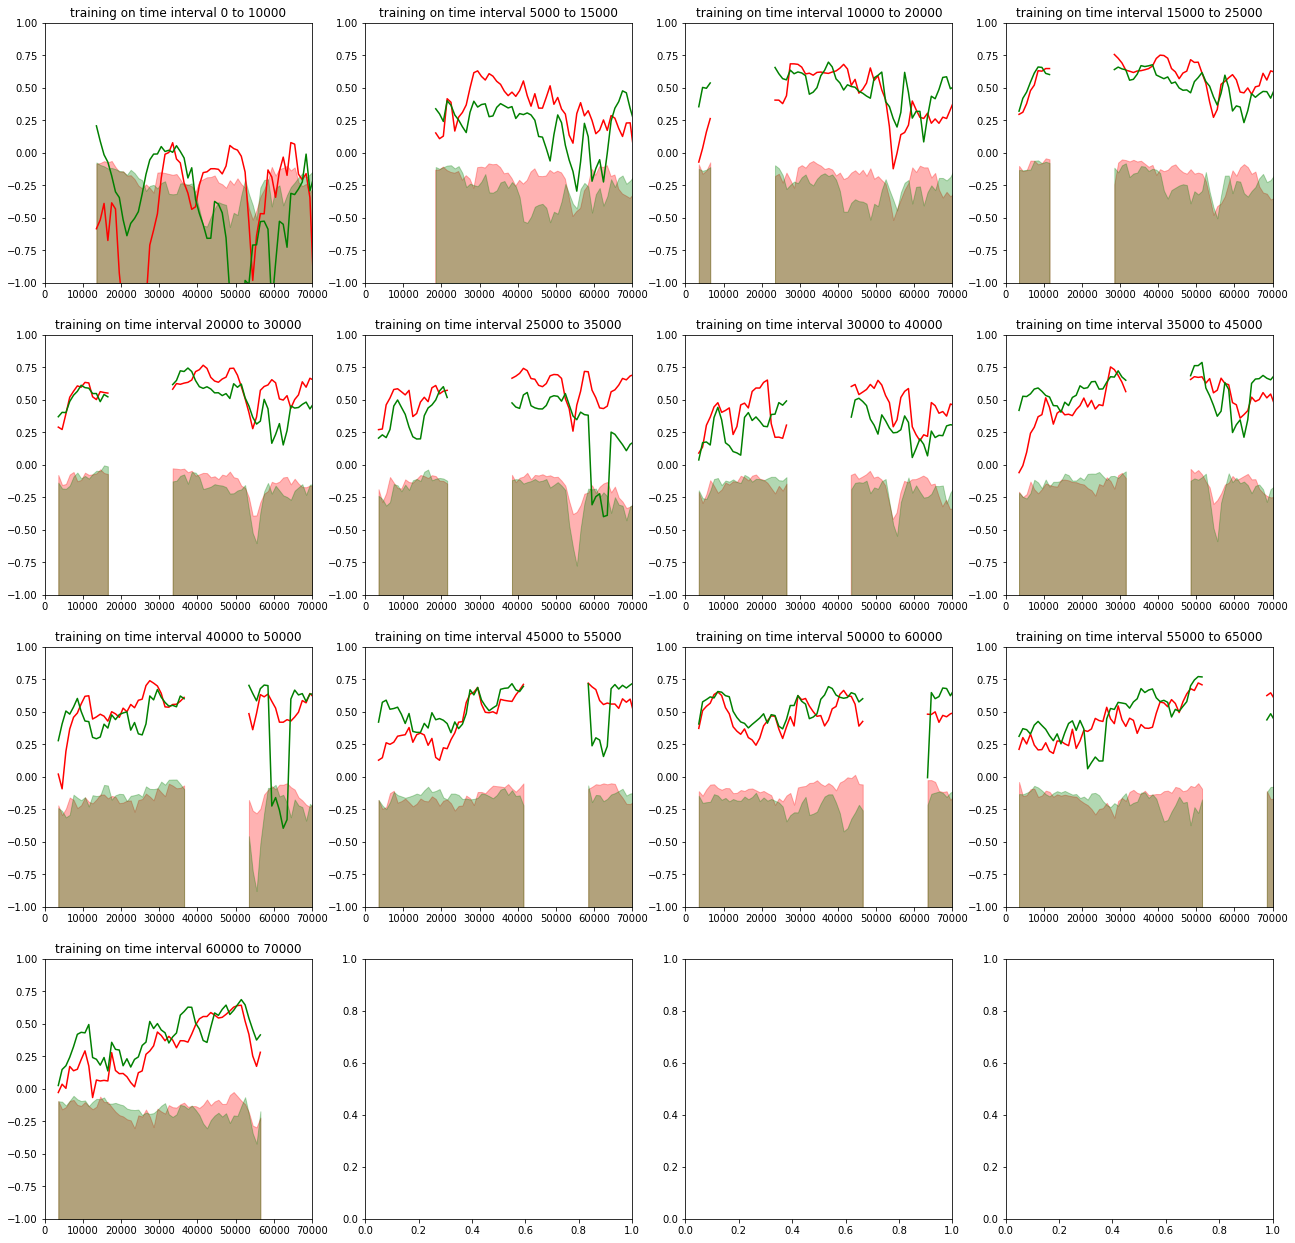

In [4]:
inst_fr = np.load('../DATA/FILES/R859_D2_inst_fr_within.npy')
x = np.load('../DATA/FILES/R859_D2_x_pos_within.npy')
y = np.load('../DATA/FILES/R859_D2_y_pos_within.npy')



fig, axs = plt.subplots(4,4,figsize=(22,22))

scaler = StandardScaler()
inst_fr = scaler.fit_transform(inst_fr)

print(np.shape(inst_fr))

dt = 5000##10000
train_size = 10000##16000
buffer = 1000
test_size = 5000
window = 1000

num_shuffles = 1000 ## to be changed to 1000
alpha_val = 0.3

nrepeats = 1
##for i in range(0, 2):##int(np.floor(len(inst_fr)/dt))):
for i in range(0, int(np.floor((len(inst_fr)-train_size)/dt))):
    print('starting',i*dt, i*dt+ train_size)
    all_xtest_scores= []
    all_xtest_scores_other = []
    all_ytest_scores= []
    all_ytest_scores_other = []
    for shuffling in range(-1, num_shuffles):
        ##print(shuffling)
        inst_fr = np.load('../DATA/FILES/R859_D2_inst_fr_within.npy')
        if shuffling>=0:
            shuff_start = np.random.choice(len(inst_fr),1)[0]
            shuff_inst_fr = np.vstack((inst_fr[shuff_start:,:], inst_fr[0:shuff_start,:]))
            inst_fr = shuff_inst_fr
        
        xtest_scores= []
        xtest_scores_other = []
        X_train = inst_fr[i*dt: (i)*dt+ train_size]
        y_train = x[i*dt: (i)*dt+ train_size]
        model = LinearRegression()
        model.fit(X_train, y_train)

        ytest_scores= []
        ytest_scores_other = []
        model2 = LinearRegression()
        y_train = y[i*dt: (i)*dt+ train_size]
        model2.fit(X_train, y_train)

        all_starts = []
        start = (i)*dt+ train_size + buffer
        ##print(shuffling, start)
        while start + window + test_size < len(inst_fr):

            all_starts.append((start+ start+test_size)/2)
            
            xtest_scores.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
            ytest_scores.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
            ##xtest_scores.append(np.mean(model.predict( inst_fr[start: start + test_size])-x[start: start + test_size])**2)
            ##ytest_scores.append(np.mean(model2.predict(inst_fr[start: start + test_size])-y[start: start + test_size])**2)
            
            start = start + window


        all_starts_other = []
        start = (i)*dt- buffer-test_size 
        while start >0:
            ##print('early', start, start+test_size)
            xtest_scores_other.append(model.score( inst_fr[start: start + test_size],x[start: start + test_size]))
            ytest_scores_other.append(model2.score(inst_fr[start: start + test_size] ,y[start: start + test_size]))
            ##xtest_scores_other.append((np.mean(model.predict( inst_fr[start: start + test_size])-x[start: start + test_size])**2)**.5)
            ##ytest_scores_other.append((np.mean(model2.predict(inst_fr[start: start + test_size])-y[start: start + test_size])**2)**.5)
            
            
            all_starts_other.append((start+ start+test_size)/2)
            start = start - window
        
        if shuffling == 0:
            all_xtest_scores = np.zeros((num_shuffles, len(xtest_scores)))
            all_xtest_scores_other = np.zeros((num_shuffles, len(xtest_scores_other)))
            all_ytest_scores = np.zeros((num_shuffles, len(ytest_scores)))
            all_ytest_scores_other = np.zeros((num_shuffles, len(ytest_scores_other)))
        if shuffling>0:    
            all_xtest_scores[shuffling] = np.array(xtest_scores)
            all_xtest_scores_other[shuffling] = np.array(xtest_scores_other)
            all_ytest_scores[shuffling] = np.array(ytest_scores)
            all_ytest_scores_other[shuffling] = np.array(ytest_scores_other)
        
        if shuffling <0:
            axs[int(np.floor(i/4)),i%4].plot(all_starts, xtest_scores, color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_starts, ytest_scores, color = 'green')
            axs[int(np.floor(i/4)),i%4].plot(all_starts_other, xtest_scores_other,color = 'red')
            axs[int(np.floor(i/4)),i%4].plot(all_starts_other, ytest_scores_other,color = 'green')
            axs[int(np.floor(i/4)),i%4].set_ylim(-1, 1)
    
    alpha = 0.05
    each_side = int((alpha/2)*num_shuffles)

    all_xtest_scores= np.array(all_xtest_scores)
    all_xtest_scores_other= np.array(all_xtest_scores_other)
    all_ytest_scores= np.array(all_ytest_scores)
    all_ytest_scores_other= np.array(all_ytest_scores_other)
    CI_95x1 = np.sort(all_xtest_scores, axis = 0)[-each_side]
    CI_95y1 = np.sort(all_ytest_scores, axis = 0)[-each_side]
    CI_95x0 = np.sort(all_xtest_scores, axis = 0)[each_side]
    CI_95y0 = np.sort(all_ytest_scores, axis = 0)[each_side]
    CI_95x_other1 = np.sort(all_xtest_scores_other, axis = 0)[-each_side]
    CI_95y_other1 = np.sort(all_ytest_scores_other, axis = 0)[-each_side]
    CI_95x_other0 = np.sort(all_xtest_scores_other, axis = 0)[each_side]
    CI_95y_other0 = np.sort(all_ytest_scores_other, axis = 0)[each_side]
    
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95x0,CI_95x1, alpha = alpha_val, color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts, CI_95y0,CI_95y1,alpha = alpha_val, color = 'green')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other, CI_95x_other0,CI_95x_other1,alpha = alpha_val,color = 'red')
    axs[int(np.floor(i/4)),i%4].fill_between(all_starts_other, CI_95y_other0,CI_95y_other1,alpha = alpha_val,color = 'green')
    
    axs[int(np.floor(i/4)),i%4].set_ylim(-1, 1)
    axs[int(np.floor(i/4)),i%4].set_xlim(0, 70000)
    axs[int(np.floor(i/4)),i%4].set_title('training on time interval '+ str(i*dt)+ ' to ' + str(i*dt + train_size))